### **Import libraries** 

In [ ]:
# install Kafka API
!pip install kafka-python 

     |████████████████████████████████| 246 kB 15.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.neural_network import MLPClassifier

from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

from collections import Counter

import time
import pandas as pd
import ast
import json
from kafka import KafkaConsumer


In [ ]:
# Load Static data 
train_data = pd.read_csv('/content/cicids_static_data.csv', skipinitialspace=True)
ds = pd.DataFrame(train_data)

ds = ds.sort_index(axis=1)
ds.shape


(25191, 79)

In [ ]:
# some filltaring
# drop NaN values
ds = ds.dropna()
# recheck
print("count NAN values : ",ds.isna().sum().sum())


# check for values approaching infinity
ds = ds.replace([np.inf, -np.inf], np.nan)
ds.isna().sum().sum()
print("count INF values : ",ds.isna().sum().sum())


# drop those values
ds = ds.dropna()
# recheck
ds.isna().sum().sum()
print("Final count INF and NAN values : ",ds.isna().sum().sum())



count NAN values :  0
count INF values :  12
Final count INF and NAN values :  0


In [ ]:
Counter(ds.Label)

Counter({'ATTACK': 2443, 'BENIGN': 22736})

In [ ]:
# apply manual label encoding 
label_dict = { 'BENIGN': 0, 'ATTACK': 1 }
ds['Label'] = [label_dict[item] for item in ds['Label']]

Counter(ds.Label)

Counter({0: 22736, 1: 2443})

In [ ]:
# split given data to train and test
x_static = ds.drop('Label', axis=1)
y_static = ds.Label 

X_train, X_test, y_train, y_test = train_test_split(x_static, y_static, test_size=0.2,stratify=y_static, random_state=42)

## **static models**

In [ ]:

# Create a Random Forest Classifier
clf_RF = RandomForestClassifier()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_RF.fit(X_train, y_train)

y_pred = clf_RF.predict(X_test)

base_clf_RF_score = accuracy_score(y_pred,y_test) # mean acc on test data
print("Testing clf_RF accuracy is:", base_clf_RF_score)

print(classification_report(y_test, y_pred))



Testing clf_RF accuracy is: 0.9976171564733916
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       1.00      0.98      0.99       489

    accuracy                           1.00      5036
   macro avg       1.00      0.99      0.99      5036
weighted avg       1.00      1.00      1.00      5036



In [ ]:
# Create a Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier

clf_DT = DecisionTreeClassifier()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_DT.fit(X_train, y_train)

y_pred = clf_DT.predict(X_test)

base_clf_DT_score = accuracy_score(y_pred,y_test) # mean acc on test data
print("Testing clf_DT accuracy is:", base_clf_DT_score)

print(classification_report(y_test, y_pred))



Testing clf_DT accuracy is: 0.9984114376489277
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4547
           1       0.99      1.00      0.99       489

    accuracy                           1.00      5036
   macro avg       0.99      1.00      1.00      5036
weighted avg       1.00      1.00      1.00      5036



In [ ]:
# Create a SVM Classifier

from sklearn import svm
clf_SVM = svm.SVC()

# Train the model using the training sets y_pred=clf.predict(X_test)
clf_SVM.fit(X_train, y_train)

y_pred = clf_SVM.predict(X_test)

base_clf_SVM_score = accuracy_score(y_pred,y_test) # mean acc on test data
print("Testing clf_SVM accuracy is:", base_clf_SVM_score)

print(classification_report(y_test, y_pred))


Testing clf_SVM accuracy is: 0.9303018268467037
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4547
           1       0.86      0.34      0.48       489

    accuracy                           0.93      5036
   macro avg       0.90      0.66      0.72      5036
weighted avg       0.93      0.93      0.92      5036



## get streaming data with problem 1 configuration

In [ ]:
# instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.
consumer = KafkaConsumer(
    'task1',   # change this to "task2" for the IOT Botnet Detection  ---- important ----
    bootstrap_servers="34.130.121.39:9092",
    sasl_plain_username="student",
    sasl_plain_password="uottawa",
    security_protocol="SASL_PLAINTEXT",
    sasl_mechanism="PLAIN",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [ ]:
#get stream data function
def get_kafka_data (stream_limit=150):

  # instantiate the KafkaConsumer Class using the arguments mentioned.
# do not change any arguments other than the first positional argument.

  # Data Stream flowing in.
  df = pd.DataFrame()

  cheak_stream_limit = 0
  # stream_limit = 150
  error = 0
  for message in consumer:
      # print(f"Consuming the {cheak_stream_limit+1}th data packet!")
      
      data_packet = message.value
      # print(data_packet)
        
      ##############################################
      try:
        dict_data_packet  = ast.literal_eval(data_packet.decode())#'utf-8'
        df = df.append(dict_data_packet, ignore_index=True )
    
      except:
        stream_limit +=1
        error +=1

      # finally:
      #   print("Number of error is ",error )
    
      # your adaptation logic here #
    
      ##############################################
      
      if cheak_stream_limit == stream_limit:
          break
          
      cheak_stream_limit += 1
  print("Number of error is ",error )

  df = df.sort_index(axis=1)

  return df



# stream and sliding window loop

In [ ]:
from sklearn.tree import DecisionTreeClassifier

static_model = clf_DT
adapted_model = DecisionTreeClassifier()

window_size = 20000 
Data_window = ds.iloc[0:window_size,:]
all_pred_Y_static = [] 
all_pred_Y_adapted = [] 

all_True_y = []
count = 0
steps = 50

for step in range(steps):
  time.sleep(5)

  x = Data_window.drop('Label', axis=1)
  y = Data_window.Label

  adapted_model.fit(x,y)


  stream_data = get_kafka_data(stream_limit=2000)
  stream_data['Label'] = [label_dict[item] for item in stream_data['Label']]

  count += len(stream_data)
  #_________________________________ 
  #___ FOR 
  x = stream_data.drop('Label', axis=1)
  y = stream_data.Label

  all_True_y.append (y)
  
  # predict Two models
  pred = list(static_model.predict(x))
  all_pred_Y_static.append (pred)

  pred = list(adapted_model.predict(x))
  all_pred_Y_adapted.append (pred)


  Data_window = pd.concat((Data_window, stream_data), ignore_index = True ) # Add New data
  Data_window = Data_window.drop(Data_window.index[0:len(stream_data)]) # delete old data


  print(f"Done Step {step}")



# label_dict = { 'BENIGN': 0, 'ATTACK': 1 }
# ds['Label'] = [label_dict[item] for item in ds['Label']]



Number of error is  1
Done Step 0
Number of error is  3
Done Step 1
Number of error is  4
Done Step 2
Number of error is  0
Done Step 3
Number of error is  2
Done Step 4
Number of error is  1
Done Step 5
Number of error is  2
Done Step 6
Number of error is  1
Done Step 7
Number of error is  1
Done Step 8
Number of error is  1
Done Step 9
Number of error is  3
Done Step 10
Number of error is  1
Done Step 11
Number of error is  1
Done Step 12
Number of error is  1
Done Step 13
Number of error is  1
Done Step 14
Number of error is  3
Done Step 15
Number of error is  0
Done Step 16
Number of error is  1
Done Step 17
Number of error is  0
Done Step 18
Number of error is  1
Done Step 19
Number of error is  2
Done Step 20
Number of error is  2
Done Step 21
Number of error is  0
Done Step 22
Number of error is  1
Done Step 23
Number of error is  5
Done Step 24
Number of error is  4
Done Step 25
Number of error is  4
Done Step 26
Number of error is  0
Done Step 27
Number of error is  1
Done Ste

# evaluate itiration by accuracy and F1_score and plot calssification Reprot

In [ ]:
# len(all_pred_Y)
accuracy_static = []
f1_score_static = []

accuracy_adapted = []
f1_score_adapted = []


for i in range(50):
  True_y = all_True_y[i]

# Astatic evaluation
  pred_y = all_pred_Y_static[i]

  acc = accuracy_score(True_y,pred_y)
  accuracy_static.append(acc)
  f1 = f1_score(True_y,pred_y)
  f1_score_static.append(f1)
  print (f"static model f1_score for itiration No. {i} = ",  "{:.2f} %".format(f1*100) )
  print (f"static model accuracy for itiration No. {i} = ",  "{:.2f} %".format(acc*100) )
# Adapted evaluation
  pred_y = all_pred_Y_adapted[i]

  acc = accuracy_score(True_y,pred_y)
  accuracy_adapted.append(acc)
  f1 = f1_score(True_y,pred_y)
  f1_score_adapted.append(f1)
  print (f"Adapted model f1_score for itiration No. {i} = ",  "{:.2f} %".format(f1*100) )
  print (f"Adapted model accuracy for itiration No. {i} = ",  "{:.2f} %".format(acc*100))

  print (f"       Classification Report for itiration No. {i} \n ",classification_report(True_y,pred_y))
from collections import Counter

print(Counter(True_y))



static model f1_score for itiration No. 0 =  98.90 %
static model accuracy for itiration No. 0 =  99.80 %
Adapted model f1_score for itiration No. 0 =  98.62 %
Adapted model accuracy for itiration No. 0 =  99.75 %
       Classification Report for itiration No. 0 
                precision    recall  f1-score   support

           0       1.00      1.00      1.00      1819
           1       0.99      0.98      0.99       182

    accuracy                           1.00      2001
   macro avg       0.99      0.99      0.99      2001
weighted avg       1.00      1.00      1.00      2001

static model f1_score for itiration No. 1 =  98.48 %
static model accuracy for itiration No. 1 =  99.70 %
Adapted model f1_score for itiration No. 1 =  98.73 %
Adapted model accuracy for itiration No. 1 =  99.75 %
       Classification Report for itiration No. 1 
                precision    recall  f1-score   support

           0       1.00      1.00      1.00      1804
           1       0.99      0.9

## **plot final results**

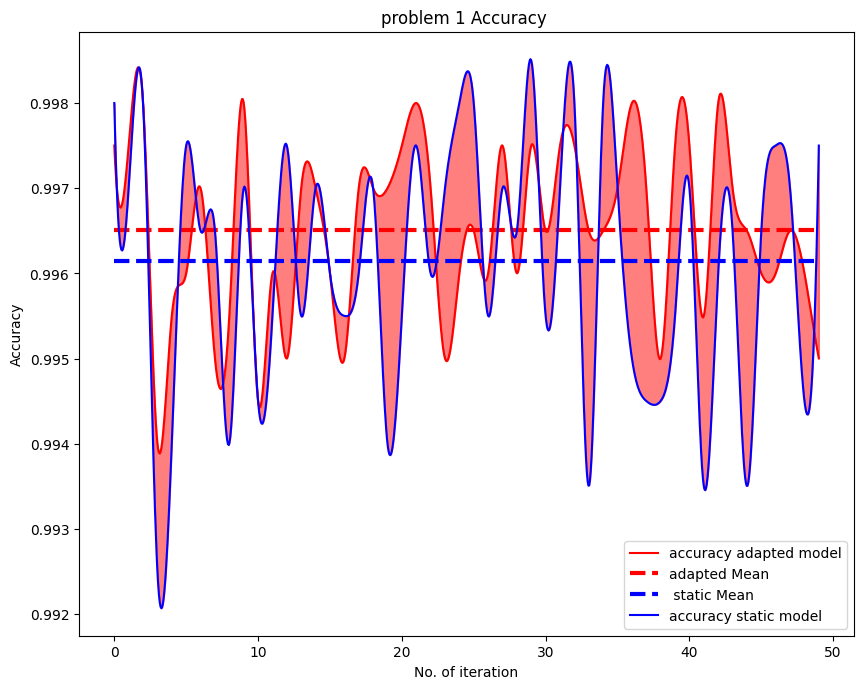

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.interpolate import make_interp_spline

x_data =  np.array(list(range(50)))

plt.figure(figsize=(10, 8), dpi=100) 

# y_data = accuracy

X_Y_Spline = make_interp_spline(x_data, accuracy_adapted)
X_ = np.linspace(x_data.min(), x_data.max(), 900)
Y_A = X_Y_Spline(X_)

y_mean = [np.mean(accuracy_adapted)]*len(x_data)
plt.plot(X_, Y_A, c='r', label='accuracy adapted model')
plt.plot(x_data, y_mean, c='r', label='adapted Mean', linestyle='--',linewidth=3)
# plt.fill_between(X_, Y_,color='b',alpha=.5)


X_Y_Spline = make_interp_spline(x_data, accuracy_static)
X_ = np.linspace(x_data.min(), x_data.max(), 900)
Y_S = X_Y_Spline(X_)

y_mean = [np.mean(accuracy_static)]*len(x_data)
plt.plot(x_data, y_mean, c='blue', label=' static Mean', linestyle='--',linewidth=3)
plt.plot(X_, Y_S, c='blue', label='accuracy static model')

# plt.plot(x_data, y_mean, c='green', label='Mean', linestyle='--')

# plt.plot(x_func, y_func, label='$f(x) = 0.388 x^2$')
plt.xlabel('No. of iteration')
plt.ylabel('Accuracy')
plt.title('problem 1 Accuracy ')
# plt.ylim(0.994, 1.001)

# plt.fill_between(X_, Y_,color='b',alpha=.5)
plt.fill_between(X_, Y_A, Y_S ,color='r',alpha=.5)


plt.legend()
plt.show()

print("\n")



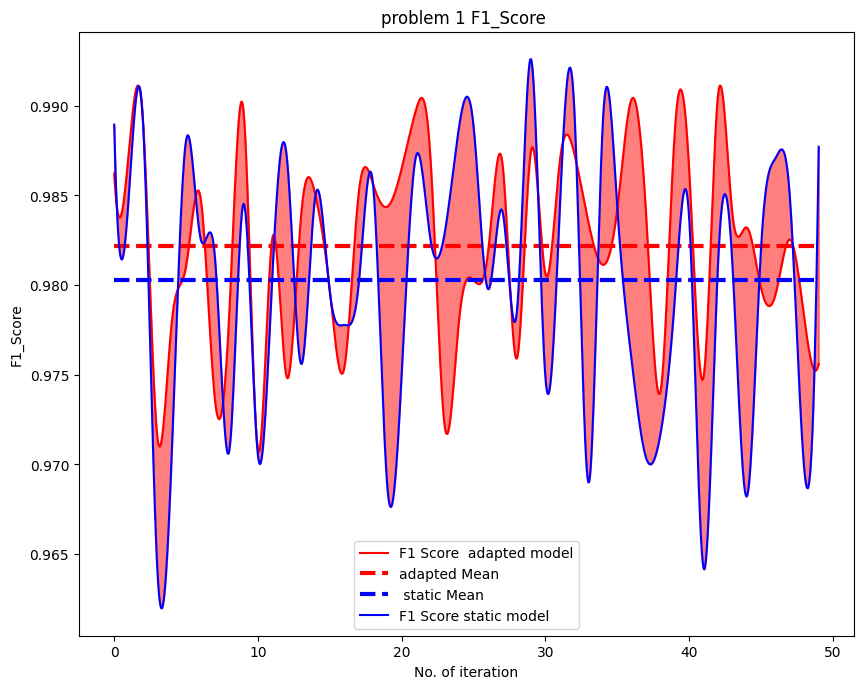

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.interpolate import make_interp_spline

plt.figure(figsize=(10, 8), dpi=100)

x_data =  np.array(list(range(50)))
# y_data = accuracy

X_Y_Spline = make_interp_spline(x_data, f1_score_adapted)
X_ = np.linspace(x_data.min(), x_data.max(), 900)
Y_A = X_Y_Spline(X_)


y_mean = [np.mean(f1_score_adapted)]*len(x_data)
plt.plot(X_, Y_A, c='r', label='F1 Score  adapted model')
plt.plot(x_data, y_mean, c='r', label='adapted Mean', linestyle='--',linewidth=3)
# plt.fill_between(X_, Y_,color='b',alpha=.5)


X_Y_Spline = make_interp_spline(x_data, f1_score_static)
X_ = np.linspace(x_data.min(), x_data.max(), 900)
Y_S = X_Y_Spline(X_)

y_mean = [np.mean(f1_score_static)]*len(x_data)
plt.plot(x_data, y_mean, c='blue', label=' static Mean', linestyle='--',linewidth=3)
plt.plot(X_, Y_S, c='blue', label='F1 Score static model')

# plt.plot(x_data, y_mean, c='green', label='Mean', linestyle='--')

# plt.plot(x_func, y_func, label='$f(x) = 0.388 x^2$')
plt.xlabel('No. of iteration')
plt.ylabel('F1_Score')
plt.title('problem 1 F1_Score ')
# plt.ylim(0.994, 1.001)

# plt.fill_between(X_, Y_,color='b',alpha=.5)
plt.fill_between(X_, Y_A, Y_S ,color='r',alpha=.5)


plt.legend()
plt.show()

print("\n")

